# Count the baking cycles
* Use the time series power and energy data to count baking cycle
* The time series has a frequency of one data per ~1 minute
* Column power_total showes power at each time point in watts
* Column energy_total showes accumulative energy at each time point in kWh
* The data includes 13 full-day records from 10/1 to 10/13

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [2]:
# plot one column of the data
def plot_data(data, col):
    seaborn.set()
    plt.rcParams["figure.figsize"] = (20,10)
    plt.plot(data.index, data[col])
    plt.ylabel(col)
    plt.show()
    
# plot three colums on the same scale to observe the temporal change
def plot_a_day(data, day_dp, day):
    dp_start, dp_end = day_dp[day-1]
    plt.plot(data[dp_start:dp_end].index, scaler.fit_transform(data[dp_start:dp_end]))
    plt.legend(data.columns)

# determine the minimum height for large spikes
# used half of the maxium power_total
# just in case the input data did not have any spikes (thus the maximum power_total would be small), use 5000
def determine_min_height(data):
    return max(5000, data.power_total.max()/2)

# plot the power_total for a given large spike
def plot_a_spike(data, spike_index, min_height):
    data_plot = data[data['spike_count']==spike_index]
    data_plot['power_total'] = data_plot['power_total'].apply(lambda x: np.nan if x < min_height else x)
    data_plot['power_total'] = data_plot['power_total'].fillna(method='ffill')
    plt.plot(data_plot.command_execution_date, data_plot.power_total)
    return data_plot

## 1. Import and visualize the raw data

In [51]:
data = pd.read_csv("aefa29b4-cf46-46c5-8202-ce9e83408f32.csv", index_col= 'command_execution_date', parse_dates=True)
data.head()

,power_total,energy_total
command_execution_date,,
2020-09-30 17:03:21,5.476826,485.705
2020-09-30 17:04:44,5.401162,485.705
2020-09-30 17:06:09,5.450449,485.705
2020-09-30 17:07:48,5.409736,485.706
2020-09-30 17:09:04,5.402555,485.706


In [4]:
data.shape

(16057, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16057 entries, 2020-09-30 17:03:21 to 2020-10-13 14:02:40
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   power_total   16057 non-null  float64
 1   energy_total  16057 non-null  float64
dtypes: float64(2)
memory usage: 376.3 KB


In [6]:
data.describe()

,power_total,energy_total
count,16057.000000,16057.000000
mean,404.265357,552.438115
std,1473.659970,35.425549
min,-0.018288,485.705000
25%,4.948895,529.676000
50%,5.241189,553.415000
75%,129.318800,584.528000
max,10195.748000,609.058000


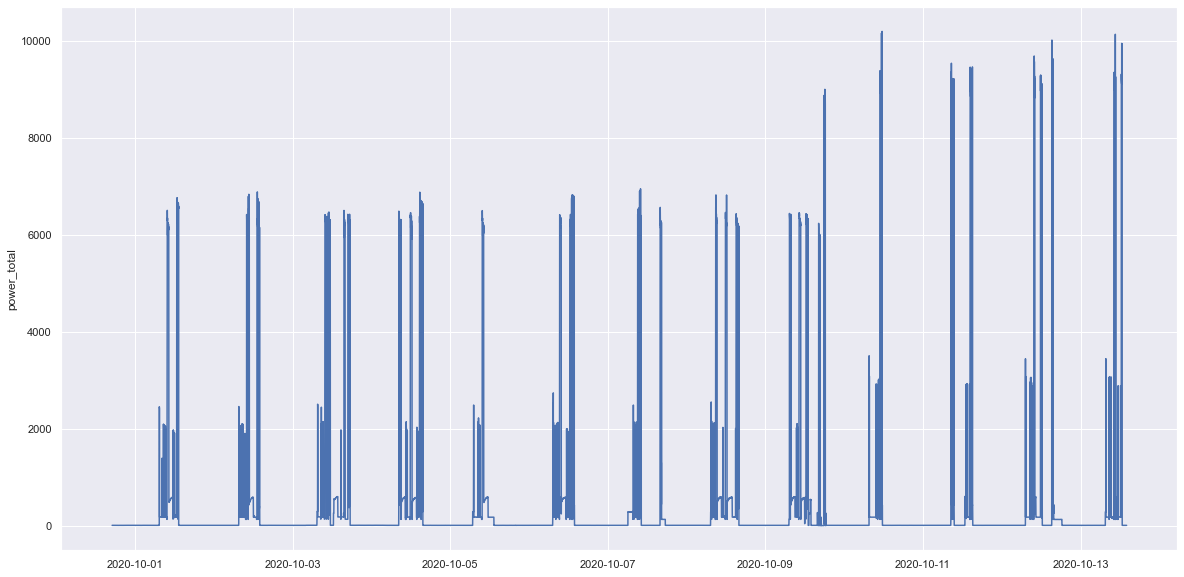

In [7]:
plot_data(data,'power_total')

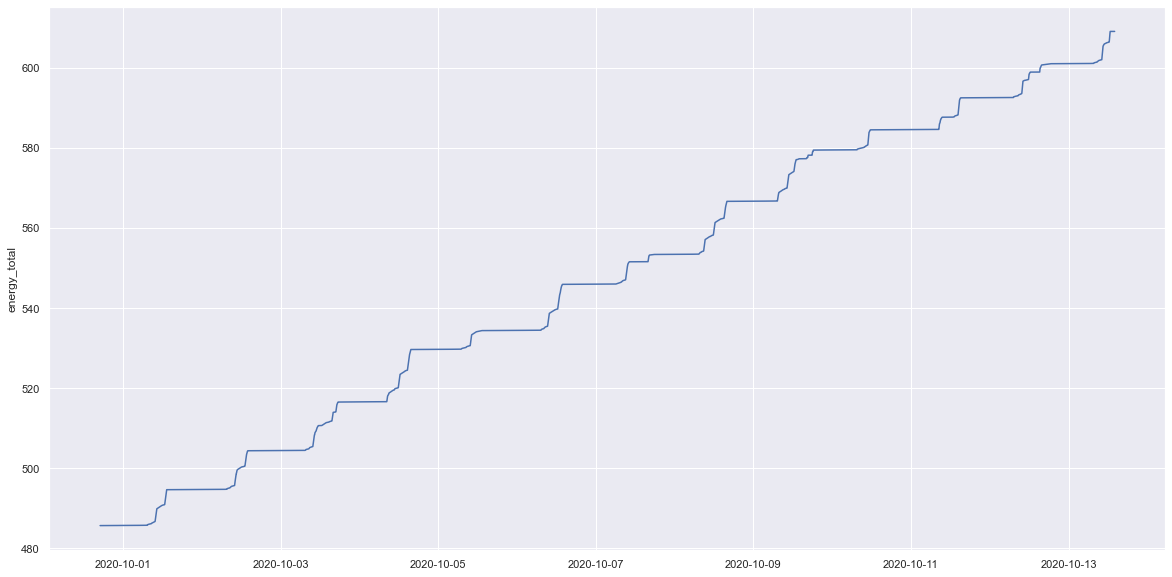

In [8]:
plot_data(data,'energy_total')

## 2. Adjust the timestamps to have consistent intervals (1 minute), then calculate energy consumption per minute

### Observations:
* The gap has a much larger variance on and before 10/6 with 90-100s, 
* then it has a much smaller variance and mostly stayed at 60s
* The power_total and energy consumption per minut (short as energy) have slightly different pattenrs across days
* The power_total has a maximum above 8000 in 10/10 to 10/13, while the maximum was in the range of 6000 from 10/1 to 10/9 (except 3 data points in 10/9)
* energy reaches the maximum fro 10/1 to 10/4
* 10/5 to 10/9 has the lowest power_total and energy
* Speculation: 10/10 a new oven was used that has enhanced power_total, but reduced energy consumption per minute

In [9]:
# check the time stamp frequency
timestamps = data.reset_index()
timestamps['gap'] = timestamps.command_execution_date.diff()
timestamps['gap'] = timestamps['gap'].apply(lambda x: x.total_seconds())
timestamps = timestamps.fillna(method='bfill')
timestamps

,command_execution_date,power_total,energy_total,gap
0,2020-09-30 17:03:21,5.476826,485.705,83.0
1,2020-09-30 17:04:44,5.401162,485.705,83.0
2,2020-09-30 17:06:09,5.450449,485.705,85.0
3,2020-09-30 17:07:48,5.409736,485.706,99.0
4,2020-09-30 17:09:04,5.402555,485.706,76.0
...,...,...,...,...
16052,2020-10-13 13:58:42,4.912920,609.058,62.0
16053,2020-10-13 13:59:40,4.759446,609.058,58.0
16054,2020-10-13 14:00:40,4.954719,609.058,60.0
16055,2020-10-13 14:01:40,5.079357,609.058,60.0


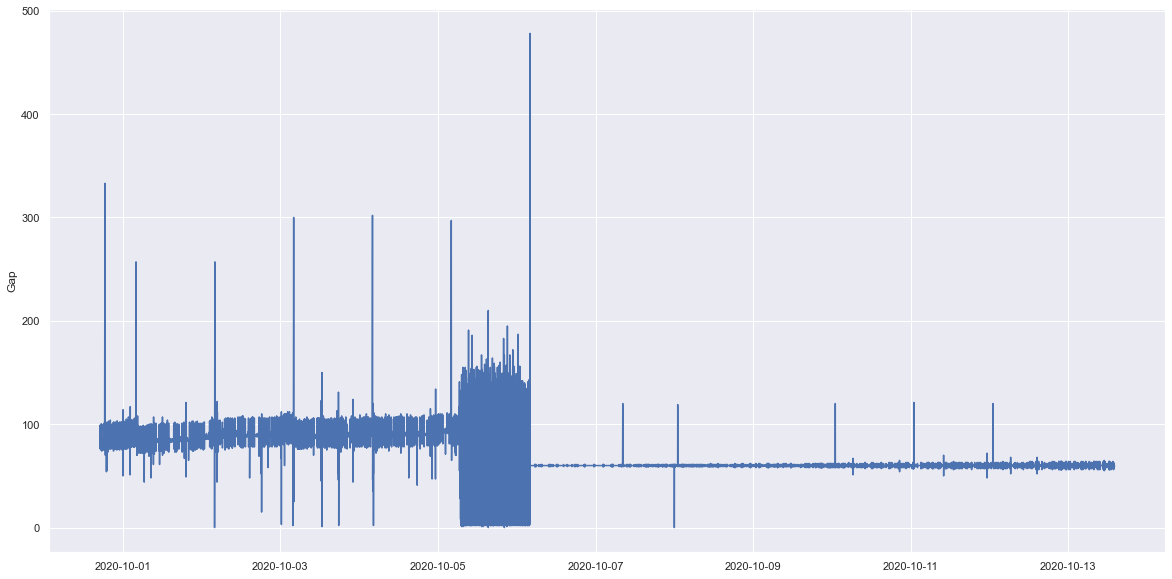

In [10]:
# The gap has a much larger variance on and before 10/6 with 90-100s, 
# then it has a much smaller variance and mostly stayed at 60s
plt.plot(timestamps.command_execution_date, timestamps.gap)
plt.ylabel("Gap")
plt.show()

In [52]:
# resample the original data to 1 timestamp per minute, interplote the missing data using the average of the neighbors
data = data.resample('T').mean()
data = data.interpolate(method='time')

In [53]:
# create an 'energy' column to show the energy consumption for each minute
data['energy'] = data.energy_total.diff()
data.head()

,power_total,energy_total,energy
command_execution_date,,,
2020-09-30 17:03:00,5.476826,485.705,NaN
2020-09-30 17:04:00,5.401162,485.705,0.000
2020-09-30 17:05:00,5.425805,485.705,0.000
2020-09-30 17:06:00,5.450449,485.705,0.000
2020-09-30 17:07:00,5.409736,485.706,0.001


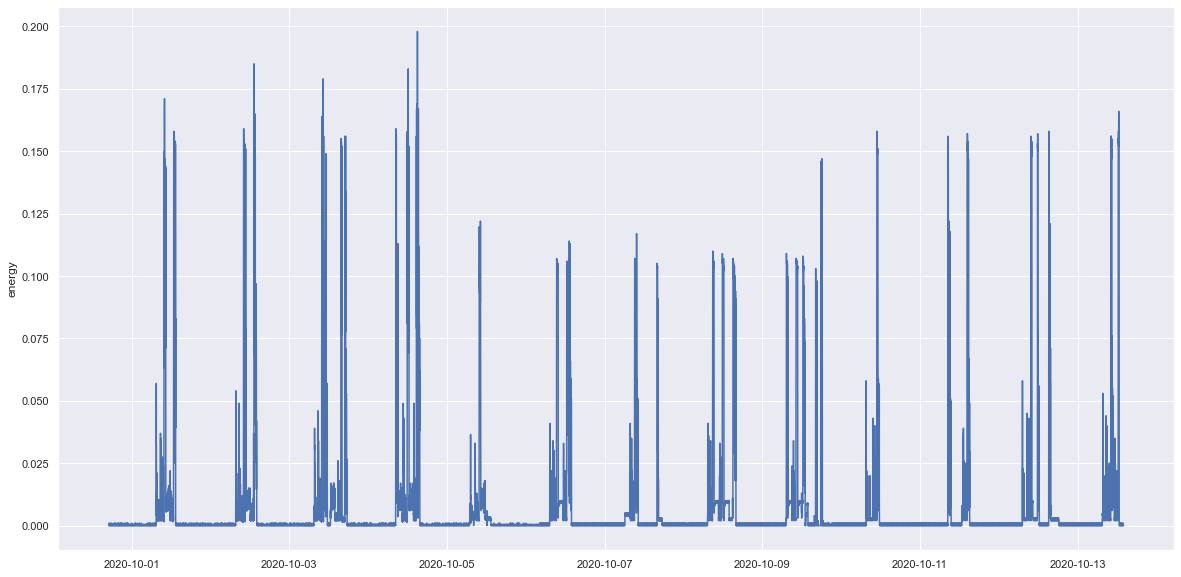

In [13]:
plot_data(data,'energy')

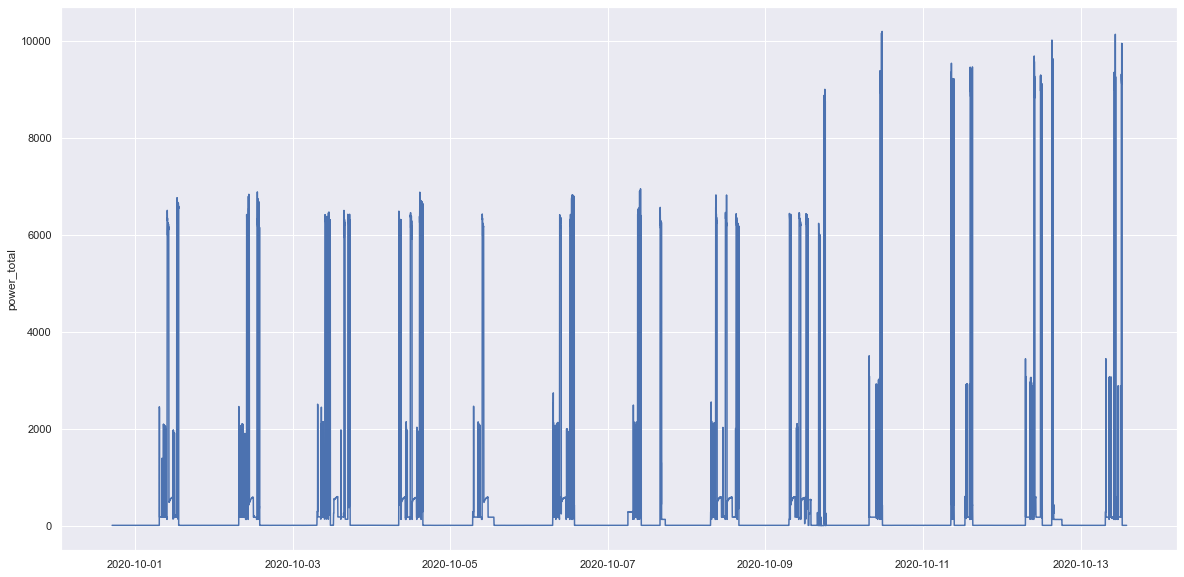

In [14]:
plot_data(data,'power_total')

## 3. Look into single day's data

### Spikes
Spikes of power_total and energy are observed during each day. During the spike, power_total and energy sustain in the range of maximum value for a range of ~8 to 46 minutes
### Warm up period
Everyday in the beginning of the day, there is a warm up period, when the power_total and energy reaches only 1/3 of the maximum vaue of that day. Sometimes there is warm up period in the middle of the day as well
### Tailing period
Almost every day (except 10/1, 10/5, 10/13), at the end of the day, there is a tailing period, when the power_total and energy reaches it's maximum every few minutes. Sometimes it happens at the end of some spikes in the middle of the day as well

In [15]:
baseline = 837 # first day starting at 800 data points, 7:00 am
dp_per_workday = 660 # for each day plot 660 data points, 11 hours, from 7 am to 6 pm
dp_per_day_total = 24*60
scaler = MinMaxScaler()

In [16]:
day_dp_start = [baseline + (i-1)*dp_per_day_total for i in range(1,14)]
day_dp_end = [i + dp_per_workday for i in day_dp_start]
day_dp = list(zip(day_dp_start, day_dp_end))
day_dp

[(837, 1497),
 (2277, 2937),
 (3717, 4377),
 (5157, 5817),
 (6597, 7257),
 (8037, 8697),
 (9477, 10137),
 (10917, 11577),
 (12357, 13017),
 (13797, 14457),
 (15237, 15897),
 (16677, 17337),
 (18117, 18777)]

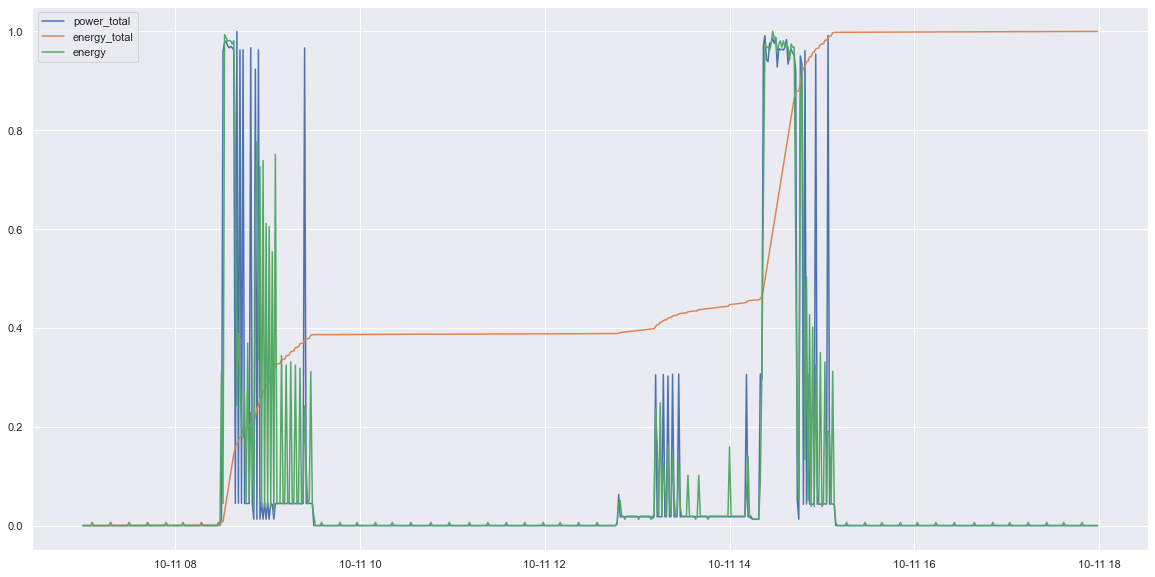

In [17]:
plot_a_day(data, day_dp, 11)

## 4. Count the number of large spikes using power_total

### Minimum height: 
* In order to exclude the warming up period, a threshold should be set to be larger than 1/3 of the maximum value. Thus 1/2 of maximum power_total is used, unless 1/2 of the  maximum is smaller than 5000, which may suggest that the input data has no spikes. In that case use 5000

### Prominence:
* We want to count the large peaks, not the small fluctuations, thus vertical threshold is set to be 1/10 of the maximum value, ~1000

### Minimum peak width:
* This dataset the minimum period of time of spike is ~ 8 minutes, so set it to be 8

In [18]:
min_height = determine_min_height(data)
min_height

5097.874

In [54]:
data = data[['power_total']]
data.reset_index(inplace=True)

In [55]:
# allowing 1 datapoint to be below the minimum height
data['baking'] = data.power_total > min_height
data['baking_last'] = data['baking'].shift(-1)
data['baking_next'] = data['baking'].shift(1)
data['baking_adjustment'] = data['baking_last']*data['baking_next'] # if both the last and next are True, baking_adjust is True
data['baking'] = data['baking'] + data['baking_adjustment']
data['baking'] = data['baking']>0

In [56]:
# calculate the duration of each spike
data['baking_status_change'] = data['baking']!=data['baking'].shift()
data.loc[data.index==0,'baking_status_change']=False

data['baking_count'] = data['baking_status_change'].cumsum()
data['baking_count'] = ((data['baking_count']+1)/2)*data['baking']
data['baking_cum'] = data['baking'].cumsum()*data['baking']

base = data.groupby(['baking_count'])['baking_cum'].min()
data['base'] = data['baking_count'].apply(lambda x: base[x])
data['baking_cum'] = (data['baking_cum'] - data['base']+1)*data['baking']
duration = data.groupby(['baking_count'])['baking_cum'].max()
data['duration'] = data['baking_count'].apply(lambda x: duration[x])

<AxesSubplot:>

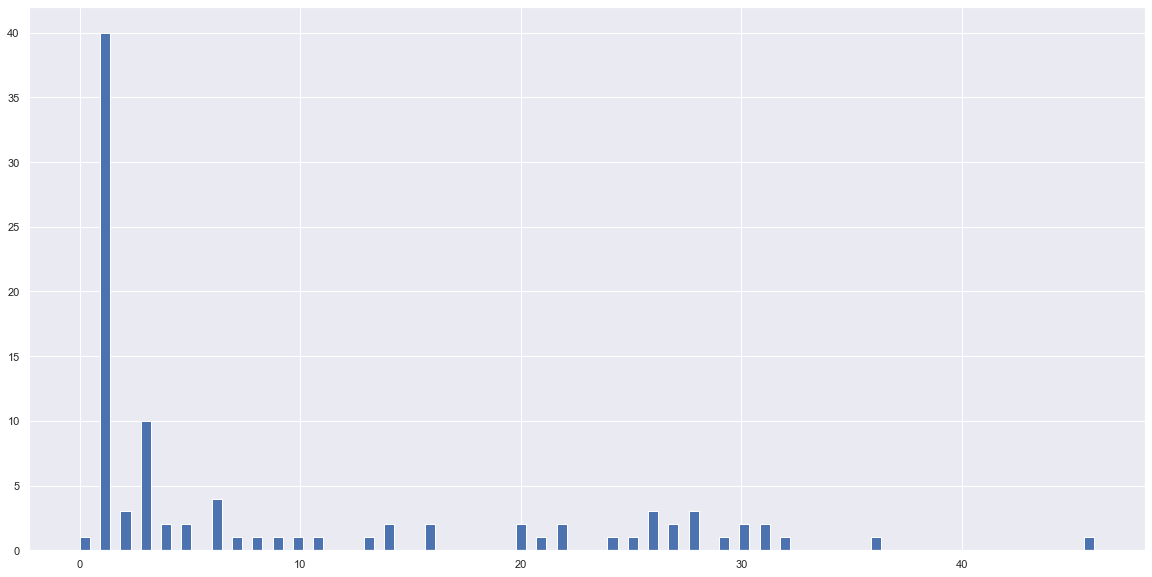

In [57]:
# plot the duration and choose threshold
duration = data.groupby(['baking_count'])['duration'].mean()
duration.hist(bins = 100)

In [61]:
# What's a reasonable minimum width of a baking cycle? 
# subway takes 12-15 minutes to bake a batch of bread
# combined with the histogram, 12 was chosen
# adjust the spikes based on minimum width of the spike
min_width = 12
data['duration'] = data['duration'].apply(lambda x: 0 if x < min_width else x)
data['baking'] = data['duration'] > 0
data['baking_status_change'] = data['baking_status_change'] & data['baking']
data['spike_count'] = data['baking_status_change'].cumsum()
data['spike_count'] = data['spike_count']*data['baking']

In [62]:
data = data[['command_execution_date','power_total','spike_count','duration']]

In [63]:
# this would be the total number of large spikes
data['spike_count'].max()

28

## 5. count the number of baking cycles
* Since large spikes has various durations (width), one spike may contain more than one baking cycle
* Visualize each spike to look for pattern
* need to fill in the potential single points that did not reach the minimum height so it does not skew the visualization

Text(0, 0.5, 'number of spikes')

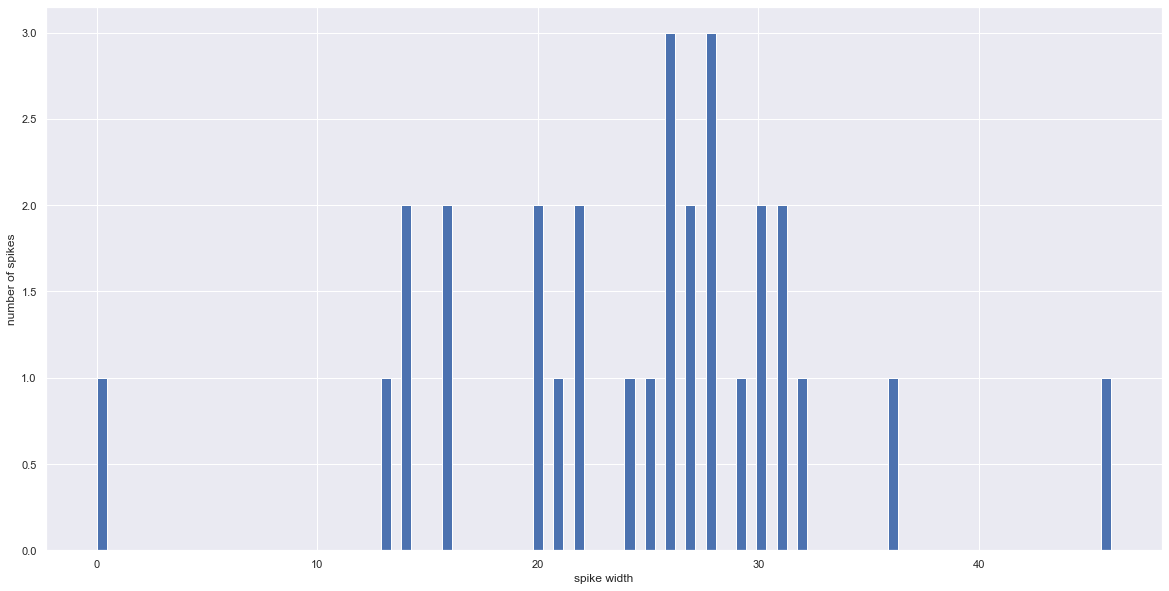

In [26]:
duration = data.groupby(['spike_count'])['duration'].mean()
duration.hist(bins = 100)
plt.xlabel('spike width')
plt.ylabel('number of spikes')

In [27]:
duration

spike_count
0      0
1     30
2     28
3     26
4     22
5     28
6     20
7     21
8     14
9     31
10    28
11    26
12    30
13    36
14    27
15    32
16    16
17    27
18    29
19    46
20    13
21    31
22    25
23    26
24    14
25    22
26    20
27    24
28    16
Name: duration, dtype: int64

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


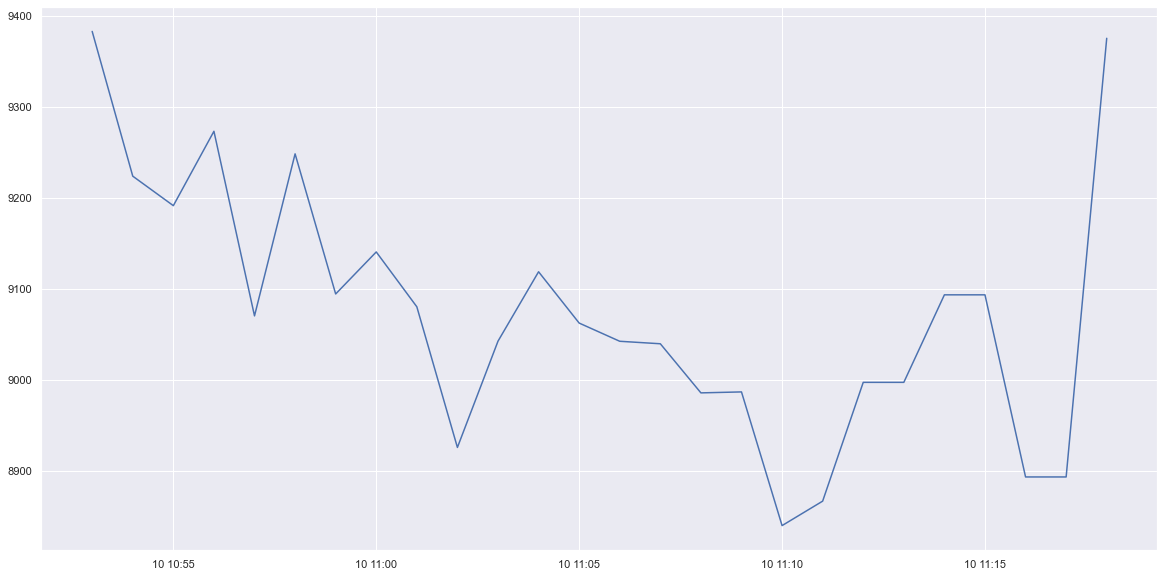

In [28]:
# some spikes seemed to have nice oscillations, but some do not
# not any clear pattern can be observed to split each spike into reasonable backing cycles
data_plot = plot_a_spike(data,23,min_height)

In [29]:
# Thus will just split each spike to baking cycle by duration, with each backing cycle = 12 min
baking_cycle = duration/min_width
baking_cycle = baking_cycle.astype(int)
baking_cycle

spike_count
0     0
1     2
2     2
3     2
4     1
5     2
6     1
7     1
8     1
9     2
10    2
11    2
12    2
13    3
14    2
15    2
16    1
17    2
18    2
19    3
20    1
21    2
22    2
23    2
24    1
25    1
26    1
27    2
28    1
Name: duration, dtype: int64

In [30]:
#Total number of baking cycle for the data
baking_cycle.sum()

48